In [1]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-paper')


import pandas as pd
from datetime import datetime
import json

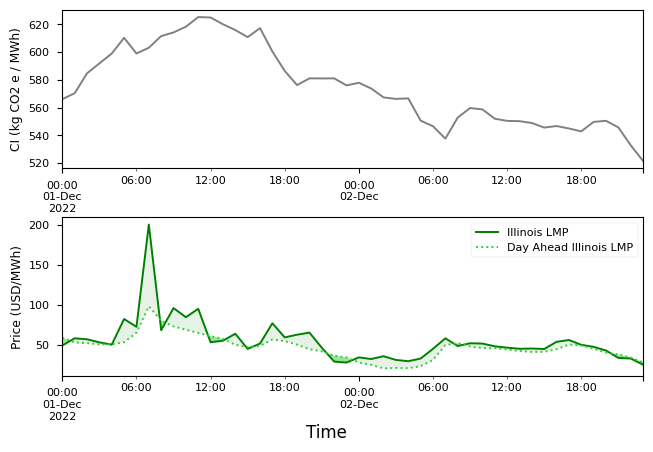

In [2]:
dec1 = pd.read_csv("carbon_intensity_pricing/12_01_2022.csv", thousands=',')
dec2 = pd.read_csv("carbon_intensity_pricing/12_02_2022.csv", thousands=',')
CARBON_INTENSITIES = json.load(open("MISO_carbon_intensity.json"))
dfs = [dec1, dec2]
for i in range(len(dfs)):
    dfs[i] = dfs[i].drop(axis=1, columns=['Other', 'Storage'])
    datetimes, grid_carbon_intensities = [], []
    for hour in dfs[i]['Hour']:
        datetimes.append(datetime(2022, 12, i+1, hour-1))
    
    dfs[i] = dfs[i].drop(axis=1, columns=['Hour'])

    dfs[i]['Time'] = datetimes


full = pd.concat(dfs, axis=0)
full = full.set_index('Time')

full[full.columns] = full[full.columns].astype('float64')
total = full['Coal'] + full['Gas'] + full['Wind'] + full['Nuclear'] + full['Solar'] + full['Hydro']

full['kg CO2 e/MWh'] = (1/total)*(CARBON_INTENSITIES['Coal']*full['Coal'] + \
    CARBON_INTENSITIES['Gas']*full['Gas'] + CARBON_INTENSITIES['Wind']*full['Wind'] + \
    CARBON_INTENSITIES['Nuclear']*full['Nuclear'] \
    + CARBON_INTENSITIES['Solar']*full['Solar'] + CARBON_INTENSITIES['Hydro']*full['Hydro']) 

full.rename(columns={'ACTUAL_LMP_ILLINOIS_HUB': 'Illinois LMP'}, inplace=True)
full.rename(columns={'DA_LMP_ILLINOIS HUB':'Day Ahead Illinois LMP'}, inplace=True)

fig, axs = plt.subplots(2)


full['kg CO2 e/MWh'].plot(ax=axs[0], color = ['grey'])
full[['Illinois LMP', 'Day Ahead Illinois LMP']].plot(ax=axs[1], color = ['green', 'limegreen'])
for line in axs[1].get_lines():
    if line.get_label() == 'Day Ahead Illinois LMP':
        line.set_linestyle(":")

    else:
        line.set_linestyle("-")



axs[0].set_ylabel('CI (kg CO2 e / MWh)')
axs[0].set_xlabel('Time')
axs[1].set_ylabel('Price (USD/MWh)')
axs[0].xaxis.label.set_visible(False)
axs[1].xaxis.label.set_visible(False)
fig.supxlabel('Time')
#where=full['Illinois LMP'] >= full['Day Ahead Illinois LMP'],
axs[1].fill_between(full.index, full['Illinois LMP'], full['Day Ahead Illinois LMP'],
                where=full['Illinois LMP'] >= full['Day Ahead Illinois LMP'],   
                facecolor='green', alpha=0.1, interpolate=True)

axs[1].fill_between(full.index, full['Illinois LMP'], full['Day Ahead Illinois LMP'],
                where=full['Illinois LMP'] < full['Day Ahead Illinois LMP'],
                facecolor='limegreen', alpha=0.5, interpolate=True)
axs[1].legend()
fig.tight_layout(pad=0.25)

fig.savefig("figs/carbon_vs_price.png", dpi=600)

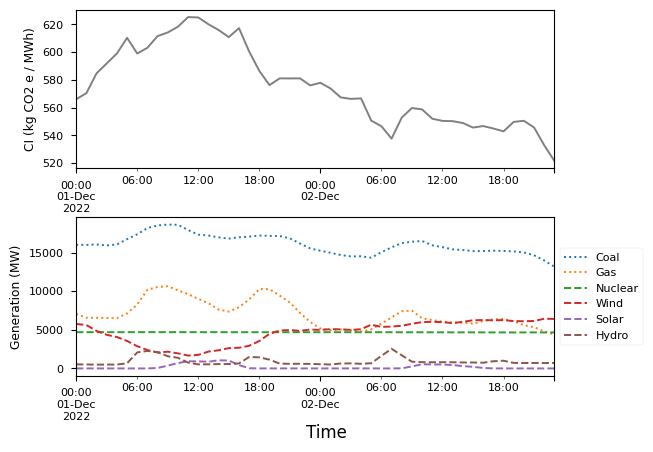

In [3]:
figprime, axsprime = plt.subplots(2)

full['kg CO2 e/MWh'].plot(ax=axsprime[0], color = ['grey'])
full[['Coal', 'Gas', 'Nuclear', 'Wind', 'Solar', 'Hydro']].plot(ax=axsprime[1])

for line in axsprime[1].get_lines():
    if line.get_label() in ['Coal', 'Gas']:
        line.set_linestyle(":")
    else:
        line.set_linestyle("--")


axsprime[0].set_ylabel('CI (kg CO2 e / MWh)')
axsprime[0].xaxis.label.set_visible(False)
axsprime[1].xaxis.label.set_visible(False)
figprime.supxlabel('Time')
axsprime[1].set_ylabel('Generation (MW)')

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
figprime.tight_layout(pad=0.25)

figprime.savefig("figs/carbon_vs_generation_amounts.png", dpi=600)

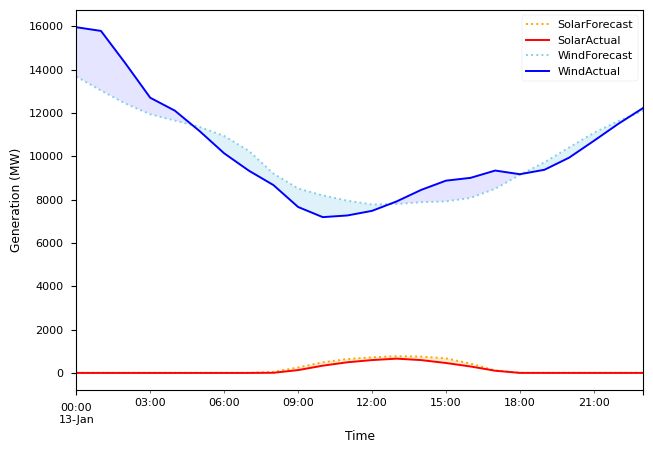

In [4]:
from matplotlib.dates import DateFormatter

solar = pd.read_csv("carbon_intensity_pricing/Day Ahead and Real-Time Solar 1-13-2023 partial day.csv")
wind = pd.read_csv("carbon_intensity_pricing/Day Ahead and Real-Time Wind 1-13-2023 partial day.csv")
joined = solar.merge(wind)
datetimes = []
for hour in joined['ActualHourEndingEST']:
    datetimes.append(datetime(2023, 1, 13, hour-1))
    
joined = joined.drop(axis=1, columns=['ActualHourEndingEST'])

joined['Time'] = datetimes
joined = joined.set_index('Time')

fig = joined.plot(color = ['orange', 'red', 'skyblue', 'blue'])
plt.fill_between(joined.index, joined['SolarForecast'], joined['SolarActual'],
                where=joined['SolarForecast'] >= joined['SolarActual'],   
                facecolor='orange', alpha=0.2, interpolate=True)

plt.fill_between(joined.index, joined['SolarForecast'], joined['SolarActual'],
                where=joined['SolarForecast'] < joined['SolarActual'],   
                facecolor='red', alpha=0.1, interpolate=True)


plt.fill_between(joined.index, joined['WindForecast'], joined['WindActual'],
                where=joined['WindForecast'] >= joined['WindActual'],   
                facecolor='skyblue', alpha=0.25, interpolate=True)

plt.fill_between(joined.index, joined['WindForecast'], joined['WindActual'],
                where=joined['WindForecast'] < joined['WindActual'],   
                facecolor='blue', alpha=0.1, interpolate=True)


for line in fig.get_lines():
    if 'Forecast' in line.get_label():
        line.set_linestyle(":")
    else:
        line.set_linestyle("-")

fig.legend()
fig.set_ylabel('Generation (MW)')
plt.tight_layout(pad=0.25)
plt.savefig("figs/renewable_forecasts_vs_actual.png", dpi=600)